### Library 

In [2]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats

path_main_folder = '/home/restor/partage/apogee-parades/AED_autoencoder'

sys.path.append(path_main_folder)

from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE_temp, CVAE
from conso.load_shape_data import *  
from Visualisation.buildProjector import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

Using TensorFlow backend.


## Recette pour apprendre un bon autoencoder conditionnel
Apres avoir augmenté le nombre de couches, inséré des sigmoids proches de l'espace latent de l'autoencoder, donner plus de poids à la loss de reconstruction (cf référence d'Antoine Rosin sur l'over pruning), et augmenter l'apprentissage, on atteint une loss de reconstruction de l'ordre de 0.4 qui donne de bons résultats et de belles projections!
On peut augmenter l'importance de la KL loss mais le temps d'apprentissage doit être augmenté (1000 pour beta=0.01 vs 500 pour beta=0.01.
Question: souhaite-t-on un espace très gaussien dans toutes les directions ? Ce serait intéressant si l'on souhaite générer des courbes de conso. Mais si l'on souhaite explorer l'espace latent, cela peut-être une contrainte potentiellement trop forte

A vérifier mais plus on passe de conditions, plus la loss de reconstruction devrait diminuer.

### Load and shape data 

In [3]:
# Load raw data
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

In [4]:
# Load Holiday day information
holiday_days_csv = os.path.join(path_data, "joursFeries.csv")
holiday_days_df = pd.read_csv(holiday_days_csv, sep=";")
holiday_days_df.ds = pd.to_datetime(holiday_days_df.ds)
holiday_days_df['is_hd'] = 1

In [5]:
# Unifomization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

In [6]:
# Change ganularity ?
name_granu = '30m'#'1H'
data_conso_df = change_granularity(data_conso_df, granularity="30min") #1H"

In [7]:
data_conso_df.head(5)

,ds,conso_nat_t0,002Th+0,005Th+0,015Th+0,027Th+0,070Th+0,110Th+0,120Th+0,130Th+0,...,630Th+0,643Th+0,645Th+0,650Th+0,675Th+0,690Th+0,747Th+0,meteo_natTh+0,type_tempo,is_holiday_day
0,2012-12-28 00:00:00,59679.0,7.7,7.90,7.2,7.10,6.40,11.30,8.70,9.10,...,10.90,13.00,11.40,11.4,13.20,14.20,15.2,8.857143,NaN,0.0
1,2012-12-28 00:30:00,58103.0,7.6,7.80,7.2,7.55,6.80,11.40,9.05,9.05,...,10.90,11.45,10.95,11.1,12.95,13.90,14.7,8.764286,NaN,0.0
2,2012-12-28 01:00:00,55354.0,7.5,7.70,7.2,8.00,7.20,11.50,9.40,9.00,...,10.90,9.90,10.50,10.8,12.70,13.60,14.2,8.671429,NaN,0.0
3,2012-12-28 01:30:00,55196.0,7.5,7.55,7.0,7.90,7.25,11.45,9.65,9.00,...,10.95,9.80,9.10,10.5,12.60,13.25,13.6,8.585714,NaN,0.0
4,2012-12-28 02:00:00,54324.0,7.5,7.40,6.8,7.80,7.30,11.40,9.90,9.00,...,11.00,9.70,7.70,10.2,12.50,12.90,13.0,8.500000,NaN,0.0


# Creer le dataset de l'autoencodeur 1 - pas de conditions

In [8]:
# Get x_conso dataframe for autoencoder purpose
x_conso = get_x_conso_autoencoder(data_conso_df, dict_colnames_conso)

In [9]:
x_conso.head(5)

,ds,conso_nat_t0,meteo_natTh+0,is_holiday_day
0,2012-12-28 00:00:00,59679.0,8.857143,0.0
1,2012-12-28 00:30:00,58103.0,8.764286,0.0
2,2012-12-28 01:00:00,55354.0,8.671429,0.0
3,2012-12-28 01:30:00,55196.0,8.585714,0.0
4,2012-12-28 02:00:00,54324.0,8.500000,0.0


### Build dataset 

In [10]:
# Split train and test
#date_test_start = datetime.date(2014,1,1)
#date_test_end = datetime.date(2015,1,1)
#dict_xconso = get_train_test_x_conso(x_conso, date_test_start, date_test_end)

dict_xconso = {'train': x_conso}

In [11]:
# Normalize x_conso
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

In [12]:
name_type_cond = 'm-wd-temp'
name_train = '0' # 1: first period ; 0 all periods
name_type_x = 'c'
type_x = ['conso']
type_cond = []#['month', 'weekday', 'temperature']

In [13]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, slidingWindowSize=0)

(1830, 13)


/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:387: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:390: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:498: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [14]:
# modify dataset to fit with new data format
#Pass a constant vector for conditions
nPoints=dataset['train']['x'][1].shape[0]
cond_pre =np.zeros((nPoints,), dtype=int)#[0] #dataset['train']['x'][1][:,:14] #les dimensions pour les conditions sans embeddings préalable
x = dataset['train']['x'][0]

dataset['train']['x'] = [x, cond_pre]#, to_emb]

### Build model

In [28]:
#on sauvegarde le dataset
path_out = os.path.join(path_main_folder, 'out')

In [29]:
# Parameters
e_dims=[48,35,24,12]#[24,12]
d_dims=[48,35,24,12]#[12,24]
emb_dims=0
cond_pre_dim = 1#dataset['train']['x'][1].shape[1]
input_dim = dataset['train']['x'][0].shape[1]
to_emb_dim = 0#dataset['train']['x'][2].shape[1]
z_dim= 5
beta = 0.005 #inferieur à 1 et plutot en dessous de 0.1

In [30]:
name_model = 'cvae_conso_NoCondition-30min-journalier'.format(name_granu,name_type_x, name_type_cond)
#name_model = 'cvae_classification'

In [31]:
name_model

'cvae_conso_NoCondition-30min-journalier'

In [32]:
model = CVAE(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_dim=1,
                  z_dim=z_dim, 
                  beta=beta,
                  name=name_model, 
                  output=path_out)

2
3
0
1
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 5), (None, 5 5409        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 5)            0           encoder[1][0]      

### Trainning model 

In [33]:
nbsample=20
from keras.callbacks import TensorBoard
from keras.callbacks import Callback

class NEpochLogger(Callback):
    def __init__(self, display):
        self.seen = 0
        self.display = display

    def on_epoch_end(self, epoch, logs={}):
        self.seen += logs.get('size', 0)
        if epoch % self.display == 0:
            metrics_log = ''
            for k in self.params['metrics']:
                if k in logs:
                    val = logs[k]
                    if abs(val) > 1e-3:
                        metrics_log += ' - %s: %.4f' % (k, val)
                    else:
                        metrics_log += ' - %s: %.4e' % (k, val)
            print('{} Epochs ... {}'.format(epoch, metrics_log))

In [34]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)
#os.path.join(path_out,name_model)

 #tensorboard = TensorBoard(log_dir=model_path,write_graph=True,write_images=True)



--- START TRAINING ---

0 Epochs ...  - loss: 16.1994 - kl_loss: 11.4759 - recon_loss: 16.1420
50 Epochs ...  - loss: 0.3101 - kl_loss: 18.3008 - recon_loss: 0.2186
100 Epochs ...  - loss: 0.2295 - kl_loss: 15.8072 - recon_loss: 0.1505
150 Epochs ...  - loss: 0.1968 - kl_loss: 14.4548 - recon_loss: 0.1245
200 Epochs ...  - loss: 0.1771 - kl_loss: 13.7184 - recon_loss: 0.1085
250 Epochs ...  - loss: 0.1642 - kl_loss: 13.3185 - recon_loss: 0.0976
300 Epochs ...  - loss: 0.1563 - kl_loss: 13.0061 - recon_loss: 0.0913
350 Epochs ...  - loss: 0.1510 - kl_loss: 12.7136 - recon_loss: 0.0874
400 Epochs ...  - loss: 0.1462 - kl_loss: 12.6102 - recon_loss: 0.0832
450 Epochs ...  - loss: 0.1436 - kl_loss: 12.4132 - recon_loss: 0.0816


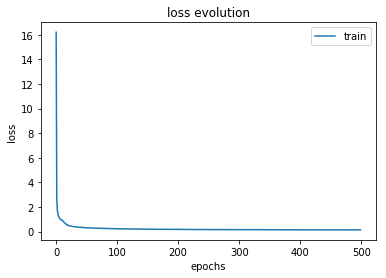

In [35]:
#model.main_train(dataset, training_epochs=200, batch_size=20, verbose=False,callbacks=[tensorboard])
#nbDispaly=
out_batch = NEpochLogger(display=50)
model.main_train(dataset, training_epochs=500, batch_size=20, verbose=False,callbacks=[tensorboard,out_batch])

#visualizer = LatentSpaceVisualizer(model_folder_path=model_path, dataset_path=labellisation_data_folder + 'sequences_dataset/sequences_et_labels.npz')
 #   visualizer.visualize_embedding_after_training()

In [36]:
with open(os.path.join(path_out,name_model,"config.txt"),'w') as file: 
    file.write(str(cond_pre_dim) + '\n')
    file.write(str(emb_dims) + '\n')
    file.write(str(e_dims) + '\n') 
    file.write(str(d_dims) + '\n') 
    file.write(str(z_dim) + '\n')
    file.write(str(beta) + '\n')

In [37]:
#sauvegarde du dataset associé
name_dataset = 'dataset.pickle'

with open( os.path.join(path_out,name_model, name_dataset), "wb" ) as file:
    pickle.dump( dataset, file )

## Loading model 

In [38]:
model.load_model(os.path.join(path_out, name_model, 'models'))

### Analysis of the latent space

In [39]:
name_set_plot = 'train'
version = '-v1'

In [40]:
#temp_emb = model.embedding.predict(dataset['train']['x'][2])
cond = dataset['train']['x'][1]
#cond = np.concatenate((cond_pre, temp_emb), axis=1)

x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond]

In [41]:
x_encoded = model.encoder.predict(input_encoder)[0]

In [42]:
# t-sne if latent space more than 2 dimension
#x_encoded = TSNE(n_components=2).fit_transform(x_encoded)

In [43]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

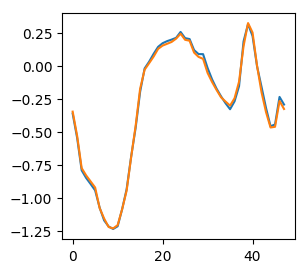

In [44]:
indice=300
x_hat = model.cvae.predict(x=dataset['train']['x'])
fig = plt.figure(dpi=100,figsize=(3,3))
#set(gca,'Color','k')
plt.plot(x[indice,])
plt.plot(x_hat[indice,])
#plt.figimage

In [45]:
nPoints=1500
#nPoints=calendar_info.shape[0]

In [46]:
log_dir="/home/restor/partage/apogee-parades/AED_autoencoder/notebooks/logs/projector_Conso_NoCond"
os.makedirs(log_dir)

FileExistsError: [Errno 17] File exists: '/home/restor/partage/apogee-parades/AED_autoencoder/notebooks/logs/projector_Conso_NoCond'

In [47]:
import os,cv2
images=createLoadProfileImages(x,x_hat,nPoints)


<Figure size 432x288 with 0 Axes>

In [48]:
sprites=images_to_sprite(images)
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes.png'), sprites)

True

In [53]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_reduced=x_encoded[0:nPoints,]
writeMetaData(log_dir,x_conso,calendar_info,nPoints)
buildProjector(x_reduced,images, log_dir)

In [55]:
x_reduced.shape

(1500, 5)

### Essayons une PCA aussi

In [56]:
log_dir="/home/restor/partage/apogee-parades/AED_autoencoder/notebooks/logs/projector_Conso_NoCond_PCA"
os.makedirs(log_dir)

FileExistsError: [Errno 17] File exists: '/home/restor/partage/apogee-parades/AED_autoencoder/notebooks/logs/projector_Conso_NoCond_PCA'

In [57]:
sprites=images_to_sprite(images)
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes.png'), sprites)

True

In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

principalComponents = pca.fit_transform(x)
x_reduced=principalComponents
x_reduced=x_reduced[0:nPoints,]

writeMetaData(log_dir,x_conso,calendar_info,nPoints)
buildProjector(x_reduced,images, log_dir)

In [21]:
pca.explained_variance_ratio_

array([0.96190808, 0.02412209, 0.00775856, 0.00327148, 0.00130234])

## Analyse prise en compte condition
Normalement on ne devrait plus pouvoir classifier aussi facilement jours de weekend et de semaine dans l'espace projeter

In [38]:
from sklearn.neighbors import KNeighborsClassifier
k=15
knn = KNeighborsClassifier(n_neighbors=k)

yWeekday=dataset['train']['x'][1].flatten()
yWeekday=yWeekday[0:nPoints,]

knn.fit(x_reduced, yWeekday)
train_accuracy= knn.score(x_reduced, yWeekday)
train_accuracy

1.0

In [39]:
prob=knn.predict_proba(x_reduced)
probScore=[prob[i][yWeekday[i]] for i in range(0,nPoints) ]
sum(probScore)/nPoints

1.0

In [40]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(x_reduced)
confusion_matrix(yWeekday,y_pred)

array([[1500]])

# Creer le dataset de l'autoencodeur 1 - condition weekday

In [41]:
# Split train and test
#date_test_start = datetime.date(2014,1,1)
#date_test_end = datetime.date(2015,1,1)
#dict_xconso = get_train_test_x_conso(x_conso, date_test_start, date_test_end)

dict_xconso = {'train': x_conso}

In [42]:
# Normalize x_conso
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

In [43]:
name_type_cond = 'm-wd-temp'
name_train = '0' # 1: first period ; 0 all periods
name_type_x = 'c'
type_x = ['conso']
type_cond = ['weekday']#normalement is ne va pas chercher quel jour de la semaine, mais si c'est un jour weekend ou semaine ['weekday', 'temperature']

In [44]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond, slidingWindowSize=0)

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:387: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:390: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/restor/partage/apogee-parades/AED_autoencoder/conso/load_shape_data.py:488: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [45]:
# modify dataset to fit with new data format
#Pass a constant vector for conditions
nPoints=dataset['train']['x'][1].shape[0]
cond_pre =dataset['train']['x'][1][:,:2]#[0] #dataset['train']['x'][1][:,:14] #les dimensions pour les conditions sans embeddings préalable
x = dataset['train']['x'][0]

dataset['train']['x'] = [x, cond_pre]#, to_emb]

### Build model

In [46]:
#on sauvegarde le dataset
path_out = os.path.join(path_main_folder, 'out')

In [91]:
# Parameters
e_dims=[48,35,24,12]#[24,12]#[48,40,30,20,14,8]
d_dims=[48,35,24,12]#[12,24]#[48,40,30,20,14,8]
emb_dims=0
cond_pre_dim = 1#dataset['train']['x'][1].shape[1]
input_dim = dataset['train']['x'][0].shape[1]
to_emb_dim = 0#dataset['train']['x'][2].shape[1]
z_dim= 5
beta = 0.05 #0.1 pour une granularite 48

In [92]:
name_model = 'cvae_conso_WeekDay-30min-journalier'.format(name_granu,name_type_x, name_type_cond)
#name_model = 'cvae_classification'

In [93]:
model = CVAE(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_dim=1,
                  z_dim=z_dim, 
                  beta=beta,
                  name=name_model, 
                  output=path_out)
                    #pDropout=0.5)

2
3
0
1
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 5), (None, 5 5409        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 5)            0           encoder[1][0]      

### Trainning model 

In [94]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)
#os.path.join(path_out,name_model)

 #tensorboard = TensorBoard(log_dir=model_path,write_graph=True,write_images=True)



--- START TRAINING ---

0 Epochs ...  - loss: 0.4903 - kl_loss: 5.9045 - recon_loss: 0.1951
50 Epochs ...  - loss: 0.4854 - kl_loss: 5.9023 - recon_loss: 0.1903
100 Epochs ...  - loss: 0.4835 - kl_loss: 5.9191 - recon_loss: 0.1876
150 Epochs ...  - loss: 0.4866 - kl_loss: 5.9671 - recon_loss: 0.1882
200 Epochs ...  - loss: 0.4933 - kl_loss: 6.0259 - recon_loss: 0.1920
250 Epochs ...  - loss: 0.4882 - kl_loss: 5.9944 - recon_loss: 0.1885
300 Epochs ...  - loss: 0.4877 - kl_loss: 6.0041 - recon_loss: 0.1875
350 Epochs ...  - loss: 0.4852 - kl_loss: 5.9958 - recon_loss: 0.1854
400 Epochs ...  - loss: 0.4846 - kl_loss: 6.0221 - recon_loss: 0.1835
450 Epochs ...  - loss: 0.4811 - kl_loss: 5.9918 - recon_loss: 0.1815


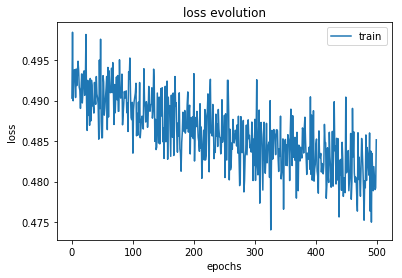

In [96]:
#model.main_train(dataset, training_epochs=200, batch_size=20, verbose=False,callbacks=[tensorboard])
model.main_train(dataset, training_epochs=500, batch_size=20, verbose=False,callbacks=[tensorboard,out_batch])

#visualizer = LatentSpaceVisualizer(model_folder_path=model_path, dataset_path=labellisation_data_folder + 'sequences_dataset/sequences_et_labels.npz')
 #   visualizer.visualize_embedding_after_training()

In [97]:
with open(os.path.join(path_out,name_model,"config.txt"),'w') as file: 
    file.write(str(cond_pre_dim) + '\n')
    file.write(str(emb_dims) + '\n')
    file.write(str(e_dims) + '\n') 
    file.write(str(d_dims) + '\n') 
    file.write(str(z_dim) + '\n')
    file.write(str(beta) + '\n')

In [98]:
#sauvegarde du dataset associé
name_dataset = 'dataset.pickle'

with open( os.path.join(path_out,name_model, name_dataset), "wb" ) as file:
    pickle.dump( dataset, file )

## Loading model 

In [99]:
model.load_model(os.path.join(path_out, name_model, 'models'))

### Analysis of the latent space

In [100]:
name_set_plot = 'train'
version = '-v1'
nPoints=1500

In [101]:
#temp_emb = model.embedding.predict(dataset['train']['x'][2])
cond = dataset['train']['x'][1]
#cond = np.concatenate((cond_pre, temp_emb), axis=1)

x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond]

In [102]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])

In [103]:
log_dir="/home/restor/partage/apogee-parades/AED_autoencoder/notebooks/logs/projector_Conso_WeekDay_4couches"
os.makedirs(log_dir)

FileExistsError: [Errno 17] File exists: '/home/restor/partage/apogee-parades/AED_autoencoder/notebooks/logs/projector_Conso_WeekDay_4couches'

In [104]:
import os,cv2
images=createLoadProfileImages(x,x_hat,nPoints)

<Figure size 432x288 with 0 Axes>

In [63]:

sprites=images_to_sprite(images)
cv2.imwrite(os.path.join(log_dir, 'sprite_4_classes.png'), sprites)

True

In [105]:

x_reduced=x_encoded[0:nPoints,]
writeMetaData(log_dir,x_conso,calendar_info,nPoints)
buildProjector(x_reduced,images,log_dir)

## Analyse classification de conditions dans espace latent
Normalement on ne devrait plus pouvoir classifier aussi facilement jours de weekend et de semaine dans l'espace projeter

In [106]:
from sklearn.neighbors import KNeighborsClassifier
k=20
knn = KNeighborsClassifier(n_neighbors=k)

yWeekday=calendar_info['is_weekday']
yWeekday=yWeekday[0:nPoints,]

knn.fit(x_reduced, yWeekday)
train_accuracy= knn.score(x_reduced, yWeekday)
train_accuracy

0.8186666666666667

In [107]:
prob=knn.predict_proba(x_reduced)
probScore=[prob[i][yWeekday[i]] for i in range(0,nPoints) ]

In [108]:
#plutot sous forme d un probability score
sum(probScore)/nPoints

0.7254666666666671

In [109]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(x_reduced)
confusion_matrix(yWeekday,y_pred)

#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

array([[ 219,  210],
       [  62, 1009]])

## classification si espace random


In [110]:
x_reduced_random=np.random.rand(nPoints,1)
knn_random = KNeighborsClassifier(n_neighbors=k)
knn_random.fit(x_reduced_random, yWeekday)
train_accuracy_random= knn_random.score(x_reduced_random, yWeekday)
train_accuracy_random

0.7113333333333334

In [111]:
prob_random=knn_random.predict_proba(x_reduced_random)
probScore_random=[prob_random[i][yWeekday[i]] for i in range(0,nPoints) ]


In [112]:
#plutot sous forme d un probability score
sum(probScore_random)/nPoints

0.6084333333333329

In [113]:
from sklearn.metrics import confusion_matrix
y_pred_random = knn_random.predict(x_reduced_random)
confusion_matrix(yWeekday,y_pred_random)

#normalement on doit trouver 5/7 de jours de semaine (1082 sur 1500) et 2/7 de jours de weekend (428 sur 1500)  

array([[   7,  422],
       [  11, 1060]])

## Analyse classification de catégorie holidays dans espace latent
Normalement on ne devrait plus pouvoir classifier aussi facilement jours de weekend et de semaine dans l'espace projeter

In [114]:
from sklearn.neighbors import KNeighborsClassifier
k=5
knn = KNeighborsClassifier(n_neighbors=k)

yHd=calendar_info['is_hd']
yHd=yHd[0:nPoints,]
indicesHd=[i for i in range(0, nPoints) if yHd[i] == 1]
yHd_only=yHd[yHd==1]

x_reduced_Hd=x_reduced[indicesHd,]

knn.fit(x_reduced, yHd)
train_accuracy= knn.score(x_reduced, yHd)
scoreHd=np.sum(np.abs((knn.predict(x_reduced_Hd))))/len(indicesHd)
scoreHd
#train_accuracy

0.7777777777777778